<h1>Pima Indian Diabetes Dataset - GA HW #2</h1>
<h3>Zen Yui | 2016-02-06</h3>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import learning_curve
from sk_modelcurves.learning_curve import draw_learning_curve

In [12]:
#set the matplotlib plotting style
plt.style.use('ggplot')

In [13]:
#import the dataset, assign to a pandas DataFrame
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
cols = ['pregnancies','glucose','bp','skin','insulin','bmi','ped','age','class']
features = cols[:-1]
df = pd.read_csv(data_url, header=None, names=cols)

34.9% diabetes rate overall


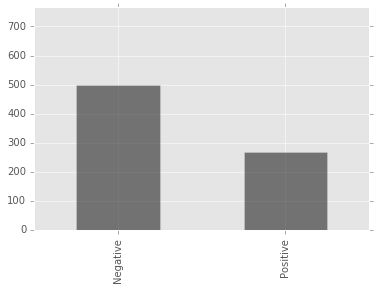

In [14]:
# overall positive diagnoses rate
print(str(round(df['class'].mean(),4) * 100) + '% diabetes rate overall');
df['class'].map({1:'Positive',0:'Negative'}).value_counts().plot(kind='bar', color='k', alpha=0.5, ylim=(0,len(df)))

<u><h3>Dataset and goals</h3></u>

<strong><i>goal:</i></strong> To determine the most effecitve machine learning algorithm for predicting diabetes given the provided dataset

<strong><i>preliminary observations:</i></strong>
<ul>
<li>8 attributes and a positive/negative diabetes diagnosis</li>
<li>768 Pima Indian patients</li>
<li>all patients are female</li>
<li>all patients at leats 21 years of age</li>
<li>all features are numeric</li>
<li>overall diagnoses rate is ~35%</li>
</ul>


<strong><i>data dictionary:</i></strong>
<ul>
<li><strong>preg</strong> (int) - <i>Number of times pregnant</i></li>
<li><strong>glu</strong> (int) - <i>Plasma glucose concentration a 2 hours in an oral glucose tolerance test</i></li>
<li><strong>bp</strong> (int) - <i>Diastolic blood pressure (mm Hg)</i></li>
<li><strong>skin</strong> (int) - <i>Triceps skin fold thickness (mm)</i></li>
<li><strong>insulin</strong> (int) - <i>2-Hour serum insulin (mu U/ml)</i></li>
<li><strong>bmi</strong> (float) - <i>Body mass index (weight in kg/(height in m)^2)</i></li>
<li><strong>ped</strong> (float) - <i>Diabetes pedigree function</i></li>
<li><strong>age</strong> (int) - <i>Age (years)</i></li>
<li><strong>class</strong> (int) - <i>Class variable (0 or 1) - 1 is a positive diabetes diagnosis</i></li>
</ul>

<u><h3>Features and hypothesis</h3></u>
<br>
<strong><i>I see the features as belonging to one of two categories:</i></strong>
<ul>
<li><u>Health attributes</u>: preg, bp, skin, bmi, age</li>
<li><u>Diabetes tests</u>: glu, insulin, ped</li>
</ul>

<strong><i>I expect the following to be indicative of diabetes:</i></strong>
<ul>
<li>The patients with better "health attributes" will be less likely to develop diabetes</li>
<li>The diabetes-specific tests will have a high impact on positive diagnoses</li>
<li>Older patients will probably be more susceptible if overal "health attributes" are poor</li>
</ul>

<strong><i>I will look out for the following possibilities:</i></strong>
<ul>
<li>bmi and skin may be correlated and therefore redundant</li>
<li>The "diabetes tests" could be highly correlated and redundant</li>

</ul>

<u><h3>Missing Values</h3></u>
- There aren't any blank values, but some values are "0" when that is obviously impossible.
- The following section investigates each feature's distribution and instances of "0" values

In [15]:
# specifically paying attention to "min==0" features
df.describe().drop('class', axis=1)

,pregnancies,glucose,bp,skin,insulin,bmi,ped,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [16]:
# looking at summary data without any "0" values
df[df!=0].describe().drop('class',axis=1)

,pregnancies,glucose,bp,skin,insulin,bmi,ped,age
count,657.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000
mean,4.494673,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885
std,3.217291,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,2.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000
50%,4.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000
75%,7.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [17]:
# Filling glucose, bp, skin, and insulin with np.nan as "0" values are meaningless
for feature in ['glucose','bp','skin','insulin','bmi']:
    df.loc[:,feature].replace(to_replace=0, value=np.nan, inplace=True)

glucose     0.651042
bp          4.557292
skin       29.557292
insulin    48.697917
bmi         1.432292
dtype: float64


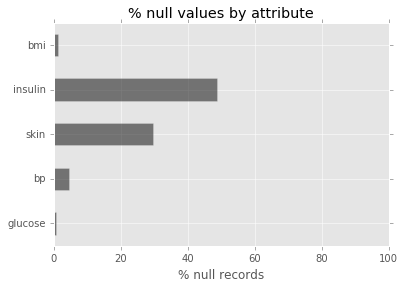

In [18]:
# dividing sum of null values (where null == 1) by count of all values
ldf = len(df)
na = df.isnull().sum() * 1.0 / ldf * 100
na = na[na>0]
print(na)
na.plot(kind='barh', xlim=(0,100), color='k', alpha=0.5)
plt.title('% null values by attribute')
plt.xlabel('% null records');

<h3>investigate correlation of features</h3>
<br>
As expected, bmi and skin seem highly correlated, and glucose and insulin seem highly correlated

In [19]:
dfcorr = df.corr()
dfcorr.where(dfcorr >.5,'')

,pregnancies,glucose,bp,skin,insulin,bmi,ped,age,class
pregnancies,1,,,,,,,0.544341,
glucose,,1,,,0.581186,,,,
bp,,,1,,,,,,
skin,,,,1,,0.648214,,,
insulin,,0.581186,,,1,,,,
bmi,,,,0.648214,,1,,,
ped,,,,,,,1,,
age,0.544341,,,,,,,1,
class,,,,,,,,,1


<h3>create helper function to plot the diagnosis rate for each feature</h3>
<br>
Since features are all numeric, I created a function that divides feature into groups of equal size using the pandas.cut() function, and analyzed the distribution of positive diagnoses along these groups.

In [20]:
def plot_diabetes_rate(data, feature_name, bins, h_size=15, v_size=5):
    ''' plot the diabetes rate for feature "feature_name" in dataframe "data"
        segmented into "bins" # of groups using the pandas.cut() function
        
        Axis 1 is a distribution by bin of positive and negative diagnoses, stacked
        Axis 2 is shows % positive diagnoses per bin
    '''
    # create two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(h_size, v_size))
    
    # group into "bins" with pd.cut()
    data_grp = data.groupby(pd.cut(data[feature_name], bins))['class']
    
    #plot distribution counts
    catvals = pd.concat([data_grp.sum(), data_grp.count()], axis=1)
    catvals.columns = ['positive','negative']
    cat_title = 'diagnosis distribution given ' + feature_name
    catvals.plot(kind='bar', stacked=True, color=['g','k'], alpha=0.5, title=cat_title, ax=axes[0])
    
    # plot diabetes rate per bin
    mean_title = 'positive diagnosis given ' + feature_name
    data_grp.mean().plot(kind='bar', color='blue', alpha=0.5, ax=axes[1], title=mean_title, ylim=(0,1))

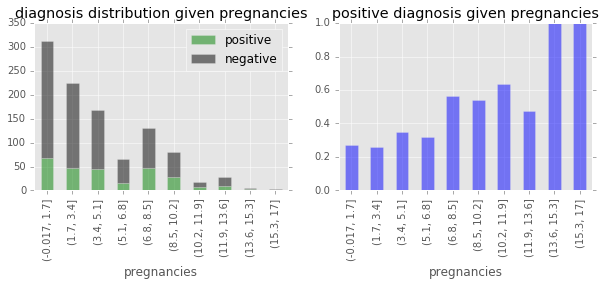

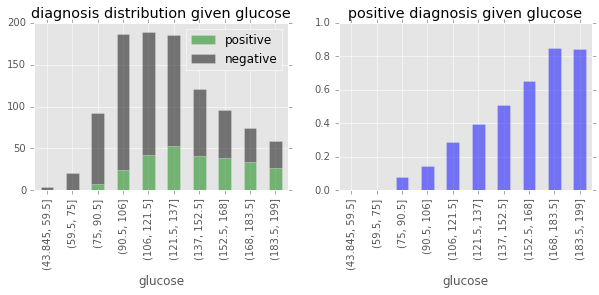

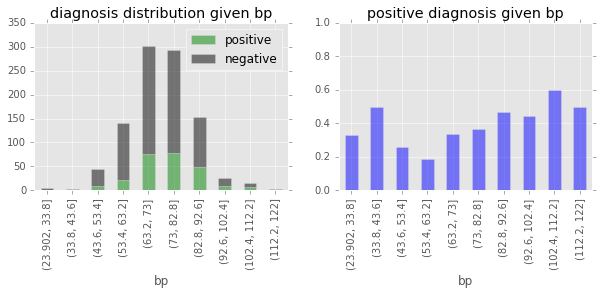

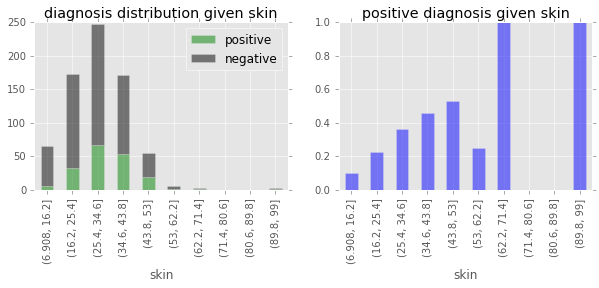

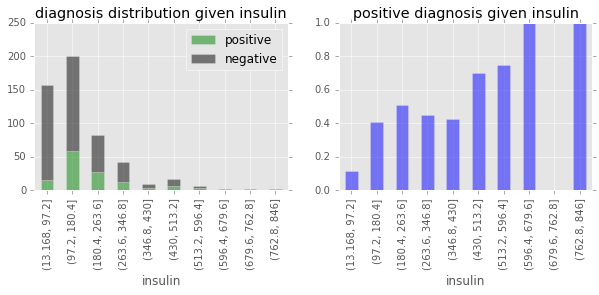

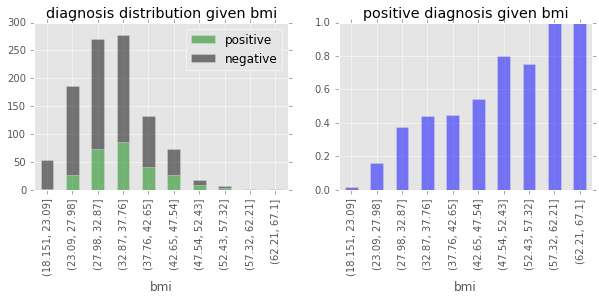

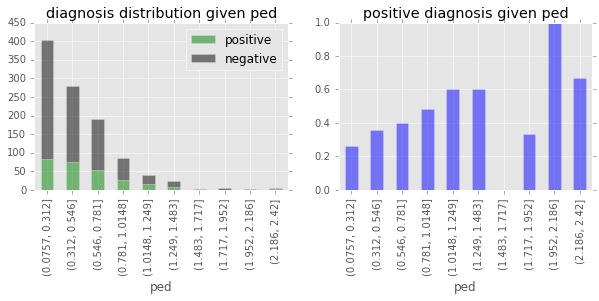

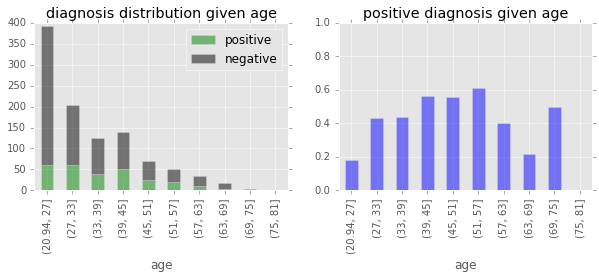

In [21]:
for f in features:
    plot_diabetes_rate(df, f, 10, 10,3)

<h3>Two dataset versions for handling missing values</h3>
<ul>
<li><strong>df1</strong>: Filling all nulls with the median value</li>
<li><strong>df2</strong>: Analyzing features by hand</li>
</ul>

<h3>Creating df1</h3>

In [22]:
# data set 1, filling all nulls with median value
df1 = df.copy()

for f in ['glucose','bmi','bp','insulin','skin']:
    med = df[f].median()
    df1[f].fillna(med, inplace=True)

df1.describe()

,pregnancies,glucose,bp,skin,insulin,bmi,ped,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<h3>Creating df2</h3>

In [23]:
df2 = df.copy()

<strong>missin feature analysis: glucose</strong>
<ul>
<li>only 0.07% of values are null</li>
<li>preliminary graphing suggests glucose is a good indicator of diabetes</li>
<li>best course of action is to drop null records</li>
</ul>

In [24]:
# drop rows where glucose is null
df2.dropna(axis=0, subset=['glucose'], how='all', inplace=True)

<strong>missing feature analysis: bmi</strong>
<ul>
<li>diagnoses seem more likely as bmi increases</li>
<li>only 1.4% of bmi values missing</li>
<li>best decision is to drop the null records</li>
</ul>

In [25]:
# drop rows where bmi is null
df2.dropna(axis=0, subset=['bmi'], how='all', inplace=True)

<strong>missing feature analysis: bp</strong>
<ul>
<li>only 4.6% of values are null</li>
<li>best course of action is to drop null records</li>
</ul>

In [26]:
# drop rows where bp is null
df2.dropna(axis=0, subset=['bp'], how='all', inplace=True)

<strong>missing feature analysis: insulin</strong>
<ul>
<li>48% of values are null</li>
<li>fairly high correlation with glucose could make this a redundant feature</li>
<li>best decision is to drop the whole feature</li>
</ul>

In [27]:
# drop the insulin feature
df2.drop('insulin',axis=1, inplace=True)

<strong>missing feature analysis: skin</strong>
<ul>
<li>29.6% of values are null... not so many that the feature is useless</li>
<li>sking thickness seems concentrated in the lower values</li>
<li>reasonably similar mean and median values across features where skin is null and not null</li>
<li>going to try filling with the median skin thickness</li>
</ul>

In [28]:
# summary of dataframe where skin is not null
df2[df2['skin'].notnull()].describe().drop('skin',axis=1)

,pregnancies,glucose,bp,bmi,ped,age,class
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,3.516917,121.030075,71.505639,32.890226,0.502966,31.614662,0.332707
std,3.312036,30.999226,12.310253,6.881109,0.344546,10.761584,0.471626
min,0.000000,56.000000,24.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,98.750000,64.000000,27.875000,0.258750,23.000000,0.000000
50%,2.000000,115.000000,72.000000,32.800000,0.416000,28.000000,0.000000
75%,5.000000,141.250000,80.000000,36.900000,0.658500,38.000000,1.000000
max,17.000000,199.000000,110.000000,67.100000,2.420000,81.000000,1.000000


In [29]:
# summary of dataframe where skin is null
df2[df2['skin'].isnull()].describe().drop('skin',axis=1)

,pregnancies,glucose,bp,bmi,ped,age,class
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,4.833333,124.244792,74.880208,31.294792,0.396625,38.161458,0.375000
std,3.321094,30.001701,12.265015,6.791585,0.282210,13.052049,0.485389
min,0.000000,44.000000,48.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,105.000000,66.000000,25.975000,0.204750,27.000000,0.000000
50%,5.000000,122.000000,74.000000,31.050000,0.287000,36.000000,0.000000
75%,7.000000,142.250000,80.500000,35.150000,0.536250,46.000000,1.000000
max,13.000000,197.000000,122.000000,52.900000,1.781000,69.000000,1.000000


In [30]:
# fill missing skin values with median value
med = df['skin'].median()
df2['skin'].fillna(med,inplace=True)

<u><h3>Standardize and split the data</h3></u>

In [31]:
df_use = df1.copy()

In [32]:
df_use.dtypes

pregnancies      int64
glucose        float64
bp             float64
skin           float64
insulin        float64
bmi            float64
ped            float64
age              int64
class            int64
dtype: object

In [33]:
# separate the data set into features and prediction
X = df_use.drop('class',axis=1)
y = df_use['class']

In [34]:
# split data into test and training data sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [35]:
# create cross validation iterator, split at 25%, random_state=0 so others can replicate
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.25, random_state=0)

In [36]:
# standard scalar
from sklearn.preprocessing import StandardScaler

In [37]:
# use StandardScalar to even out all features, convert back to DataFrame for interpretability
stdsc = StandardScaler()

In [38]:
X_train_std = pd.DataFrame(stdsc.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(stdsc.transform(X_test), columns=X_train.columns)

<h3><u>Model performance benchmarking</u></h3>
- given dataset, a likely objective would be to identify sub-populations at greater risk of developing diabetes
- a formal diagnosis of diabetes is inexpensive and quick, so the goal is to minimize false negatives
- given the goal, either recall or F1 should be used to measure model performance
- all models must perform better than 65%, the overall rate of a negative diagnosis in the data set
- just for fun, the models should also outperform the Dummy Classifier below

In [39]:
def tri_score(mod_nam, mod, X_test, y_test):
    '''Score model according to accuracy, recall, and f1 score
        and print scores to screen'''
    y_pred = mod.predict(X_test_std)
    
    s = round(accuracy_score(y_test, y_pred) * 100, 2)
    print(mod_nam + ' accuracy:\t {:.2f}%'.format(s))
    
    s = round(recall_score(y_test, y_pred) * 100, 2)
    print(mod_nam + ' recall:\t {:.2f}%'.format(s))
    
    s = round(f1_score(y_test, y_pred) * 100, 2)
    print(mod_nam + ' f1:\t {:.2f}%'.format(s))

In [40]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='stratified', random_state=0)
dummy.fit(X_train_std, y_train)
tri_score('dumb', dummy, X_test_std, y_test)

dumb accuracy:	 55.73%
dumb recall:	 37.10%
dumb f1:	 35.11%


<h3><u>kNN performance</u></h3>

In [41]:
# import kNN classifier
from sklearn.neighbors import KNeighborsClassifier

In [42]:
# create kNN classifier, GridSearchCV for best params
knn = KNeighborsClassifier()

In [43]:
parameters = {'n_neighbors':range(1,30), 'p': range(1,3), 'weights':['distance','uniform']}
# parameters = {'n_neighbors':range(1,20), 'p': range(1,3)}

clf = GridSearchCV(knn, parameters, cv=cv, scoring='f1')
clf.fit(X_train_std, y_train)
best_knn = clf.best_estimator_

In [44]:
clf.best_params_

{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}

In [45]:
tri_score('kNN', best_knn, X_test_std, y_test)

kNN accuracy:	 81.25%
kNN recall:	 61.29%
kNN f1:	 67.86%


<module 'matplotlib.pyplot' from '/Users/zen/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

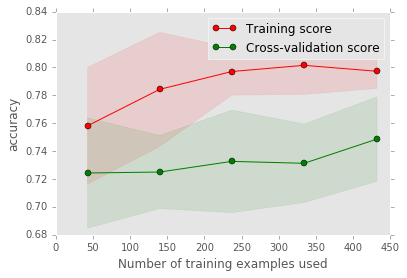

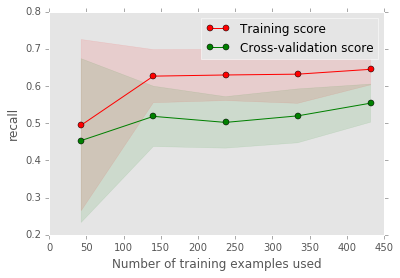

In [46]:
# draw_learning_curve(knn, X_clf, y_clf, scoring='precision', cv=5);
draw_learning_curve(best_knn, X_train_std, y_train, scoring='accuracy', cv=cv)
draw_learning_curve(best_knn, X_train_std, y_train, scoring='recall', cv=cv)

In [47]:
%timeit best_knn.predict(X_test_std)

100 loops, best of 3: 2.89 ms per loop


<strong>kNN results</strong>
- GridSearchCV yielded a kNN classifier with parameters ('n_neighbors': 9, 'p': 2, 'weights': 'uniform')
- kNN delivers 81.25% accuracy, 61.29% recall, and 67.86% f1
- at 2.15ms per loop, the model is fairly fast
- overall, kNN is a good fit for the dataset given our criteria
- kNN also has the benefit of being easy to explain

<h3><u>Naive Bayes performance</u></h3>

In [48]:
# importing GaussianNB because features are already standardized
from sklearn.naive_bayes import GaussianNB

In [49]:
# create GuassianNB, nothing to tune!
gausnb = GaussianNB()
NB = gausnb.fit(X_train_std, y_train);

In [50]:
tri_score('NB',NB, X_test_std, y_test)

NB accuracy:	 77.08%
NB recall:	 56.45%
NB f1:	 61.40%


In [51]:
%timeit NB.predict(X_test_std)

1000 loops, best of 3: 177 µs per loop


<module 'matplotlib.pyplot' from '/Users/zen/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

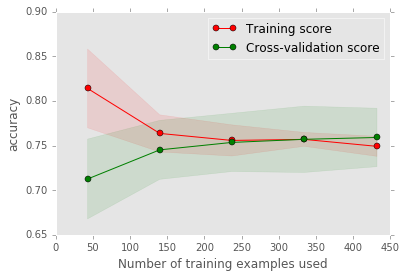

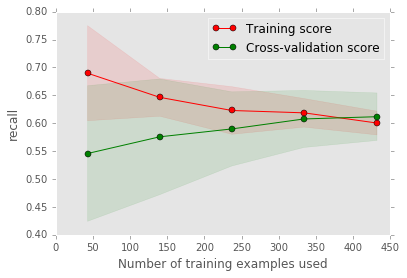

In [52]:
draw_learning_curve(NB, X_train_std, y_train, scoring='accuracy', cv=cv)
draw_learning_curve(NB, X_train_std, y_train, scoring='recall', cv=cv)

<strong>Naive Bayes results</strong>
- NB delivers 77% accuracy, 56% recall, and 61% f1
- at 81.2µs per loop, the model is significantly faster than kNN
- despite runtime performance, NB seems less performant given our criteria for minimizing false positives

<h3><u>Logistic regression performance</u></h3>

In [53]:
# create Logistic Regression classifier
from sklearn.linear_model import LogisticRegression

In [54]:
# logistic regression tuning parameters
parameters = {'C': np.linspace(1e-5, 1e5, 200), 'class_weight': [None, 'balanced']}

In [55]:
# tune and fit a standard logistic regression model with no penalty value
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=cv)

#fit to train data
clf.fit(X_train_std, y_train);

#assign best LR model
best_lr = clf.best_estimator_
clf.best_params_

{'C': 502.51257276381904, 'class_weight': None}

In [56]:
pd.DataFrame({'features': X.columns, 'coefficients': best_lr.coef_[0]})

,coefficients,features
0,0.325651,pregnancies
1,1.123211,glucose
2,-0.195545,bp
3,-0.082778,skin
4,-0.087357,insulin
5,0.738810,bmi
6,0.282800,ped
7,0.248722,age


In [57]:
# printing scores for the LR model
tri_score('LR', best_lr, X_test_std, y_test)

LR accuracy:	 79.17%
LR recall:	 56.45%
LR f1:	 63.64%


In [58]:
%timeit best_lr.predict(X_test_std);

The slowest run took 4.23 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 75.2 µs per loop


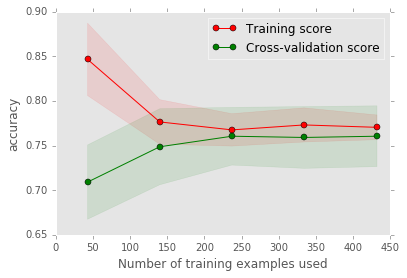

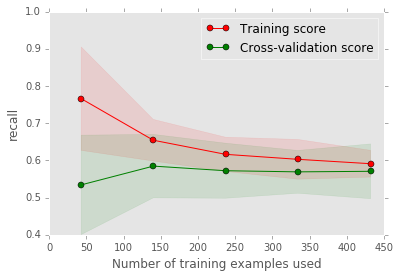

In [59]:
draw_learning_curve(best_lr, X_train_std, y_train, scoring='accuracy', cv=cv);
draw_learning_curve(best_lr, X_train_std, y_train, scoring='recall', cv=cv);

In [60]:
# create a Lasso LR model
lr_l1 = LogisticRegression(penalty='l1')
clf = GridSearchCV(lr_l1, parameters, cv=cv)

#fit to train data
clf.fit(X_train_std, y_train);

#assign best LR model
best_lasso = clf.best_estimator_
clf.best_params_

{'C': 502.51257276381904, 'class_weight': None}

In [61]:
pd.DataFrame({'features': X.columns, 'coefficients': best_lasso.coef_[0]})

,coefficients,features
0,0.325635,pregnancies
1,1.123212,glucose
2,-0.195480,bp
3,-0.082718,skin
4,-0.087333,insulin
5,0.738718,bmi
6,0.282774,ped
7,0.248628,age


In [62]:
# printing scores for the Lasso model
tri_score('Lasso', best_lasso, X_test_std, y_test)

Lasso accuracy:	 79.17%
Lasso recall:	 56.45%
Lasso f1:	 63.64%


In [63]:
%timeit best_lasso.predict(X_test_std);

The slowest run took 4.93 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 76.1 µs per loop


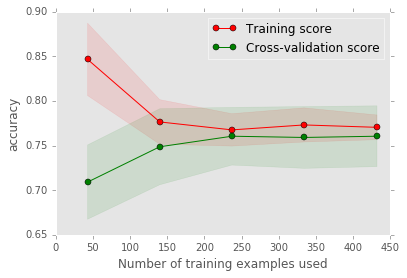

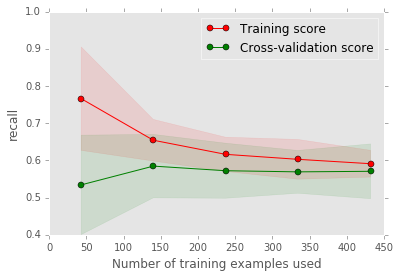

In [64]:
draw_learning_curve(best_lasso, X_train_std, y_train, scoring='accuracy', cv=cv);
draw_learning_curve(best_lasso, X_train_std, y_train, scoring='recall', cv=cv);

In [65]:
# create a Ridge LR model
lr_l2 = LogisticRegression(penalty='l2')
clf = GridSearchCV(lr_l2, parameters, cv=cv)

#fit to train data
clf.fit(X_train_std, y_train);

#assign best LR model
best_ridge = clf.best_estimator_
clf.best_params_

{'C': 502.51257276381904, 'class_weight': None}

In [66]:
pd.DataFrame({'features': X.columns, 'coefficients': best_ridge.coef_[0]})

,coefficients,features
0,0.325651,pregnancies
1,1.123211,glucose
2,-0.195545,bp
3,-0.082778,skin
4,-0.087357,insulin
5,0.738810,bmi
6,0.282800,ped
7,0.248722,age


In [67]:
# printing scores for the Ridge model
tri_score('Ridge', best_ridge, X_test_std, y_test)

Ridge accuracy:	 79.17%
Ridge recall:	 56.45%
Ridge f1:	 63.64%


In [68]:
%timeit best_ridge.predict(X_test_std);

10000 loops, best of 3: 78.5 µs per loop


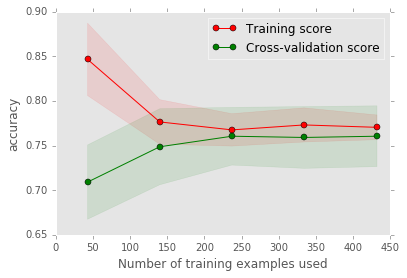

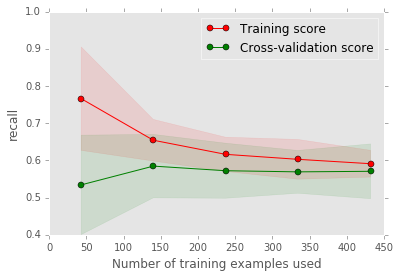

In [69]:
draw_learning_curve(best_ridge, X_train_std, y_train, scoring='accuracy', cv=cv);
draw_learning_curve(best_ridge, X_train_std, y_train, scoring='recall', cv=cv);

<strong>Logistic regression results</strong>
- untuned logistic regression predicts as well as a Lasso or Ridge model
- the untuned model operates slighly faster than the Lasso/Ridge penalties
- all three versions give more significant weight to glucose as a predictor

<h3><u>Random forest performance</u></h3>

In [70]:
# create random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [71]:
# create and fit random forest classifier
rf = RandomForestClassifier(n_estimators = 40)
rf.fit(X_train_std, y_train);

In [72]:
# scoring the RF model along the three criteria
tri_score('RF', rf, X_test_std, y_test);

RF accuracy:	 78.13%
RF recall:	 56.45%
RF f1:	 62.50%


In [73]:
# Random forest is certainly not the fastest model.
%timeit rf.predict(X_test_std)

100 loops, best of 3: 3.37 ms per loop


In [74]:
# showing the feature importance according to the RF model
features = X_train_std.columns
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,glucose,0.250230
5,bmi,0.184002
7,age,0.137836
6,ped,0.119017
4,insulin,0.085358


As predicted, glucose seems to be the greatest indicator of diabetes among the features, followed by bmi, ped, age, and insulin

<h3><u>Final model choice... kNN!</u></h3>
- Given the criteria I stated above (recall and f1 score), kNN performed the best of all other models
- Considering runtime, however, kNN was not very performant (as expected)
- In terms of accuracy, kNN also outperformed the other models (of course, this should be considered along with recall and f1 scores)
- In terms of interpretability, kNN is probably the easiest to present and explain
- With some feature engineering and further tuning, I would expect logistic regression to perform reasonably well on this data set.
- Random forest did perform reasonably well, but recall score is somewhat low, which makes me nervous about false positives.  Again, perhaps further feature engineering would benefit the Random Forest model.